# A neighborhood recomender

## Problem statement
People like to travel and explore the new places. Typically, there is a lot to see for a limited amount of the time that people have to visit a particular city. Therefore, it will be useful if an automatic recommender system will be available that could based on someone's preferences suggest the best neighborhood. 

## Data
For this case study, I will be using the same data as in week 3 assignment, but the steps can be reproduced for any type of data. Toronto neighborhood data is available on the wikipedia page and I use the csv file of location data that was provided in week 3 assignment.

In [74]:
import pandas as pd
import numpy as np
import config
import requests
import math
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Create a file config.py with your Foursquare credentials on your local machine. This file is gitignored for security reasons.

In [185]:
# foursquare API specifications
CLIENT_ID = config.CLIENT_ID
CLIENT_SECRET = config.CLIENT_SECRET
ACCESS_TOKEN = config.ACCESS_TOKEN
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

Import a wikipedia page into a pandas dataframe by scraping the table

In [76]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_df = pd.read_html(url)[0]
toronto_df = wiki_df.loc[wiki_df['Borough'] != 'Not assigned'].reset_index(drop=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [77]:
toronto_df.shape

(103, 3)

Attach the geographical location data based on the csv from provided csv

In [78]:
cwd = os.getcwd()
geo_data = pd.read_csv(cwd + '/Geospatial_Coordinates.csv')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two datasets into one

In [79]:
toronto_geo_df = toronto_df.merge(geo_data, on = 'Postal Code')
toronto_geo_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Let's do a little investigation with foursquare API on what we can get about the neighbourhood

In [80]:
def getNearbyVenues(postal_codes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pc, lat, lng in zip(postal_codes, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        urlrequest = requests.get(url).json()
        results = urlrequest["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            pc, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [81]:
toronto_venues = getNearbyVenues(postal_codes = toronto_geo_df['Postal Code'], 
                                 latitudes = toronto_geo_df['Latitude'], 
                                 longitudes = toronto_geo_df['Longitude'])
toronto_venues.head()

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,4e8d9dcdd5fbbbb6b3003c7b,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Careful & Reliable Painting,58d5b8d0102f4722b70e487b,43.752622,-79.331957,Construction & Landscaping
2,M3A,43.753259,-79.329656,649 Variety,51d769f2498e3efc78bee6b9,43.754513,-79.331942,Convenience Store
3,M3A,43.753259,-79.329656,Towns On The Ravine,5fc825cac5b8dd60907c56b3,43.754754,-79.332552,Hotel
4,M3A,43.753259,-79.329656,Sun Life,58f01a208f2c1a558cea5f7d,43.754760,-79.332783,Construction & Landscaping


In [82]:
# create pandas series with list of categories and postal codes as index. lowercase all categories
toronto_categories = toronto_venues.groupby('Postal Code')['Venue Category'].apply(list)
toronto_categories = toronto_categories.apply(lambda x: [word.lower() for word in x])
toronto_categories.head()

Postal Code
M1B                 [fast food restaurant, home service]
M1C    [golf course, construction & landscaping, home...
M1E    [bank, electronics store, spa, restaurant, mex...
M1G    [coffee shop, coffee shop, korean bbq restaura...
M1H    [caribbean restaurant, hakka restaurant, thai ...
Name: Venue Category, dtype: object

## Data exploration

In [83]:
# first let's get the list of all categories that are present
all_categories = []
for idx in toronto_categories.index:
    all_categories = all_categories + toronto_categories.loc[idx]
    
all_categories = list(set(all_categories))

In [84]:
len(all_categories)

320

In [85]:
#explore count  of neighborhoods by category
category_count = {i: 0 for i in all_categories}
for cat in all_categories:
    for idx in toronto_categories.index:
        if (cat in set(toronto_categories.loc[idx])):
            category_count[cat] = category_count[cat] + 1

In [86]:
category_count_df = pd.DataFrame(data = category_count, index = [0]).transpose().reset_index()
category_count_df.columns = ['venue', 'count']
category_count_df.sort_values(by = 'count', ascending = False, inplace = True)
category_count_df.head()

,venue,count
298,coffee shop,53
23,pizza place,49
235,park,46
12,restaurant,37
27,sandwich place,36


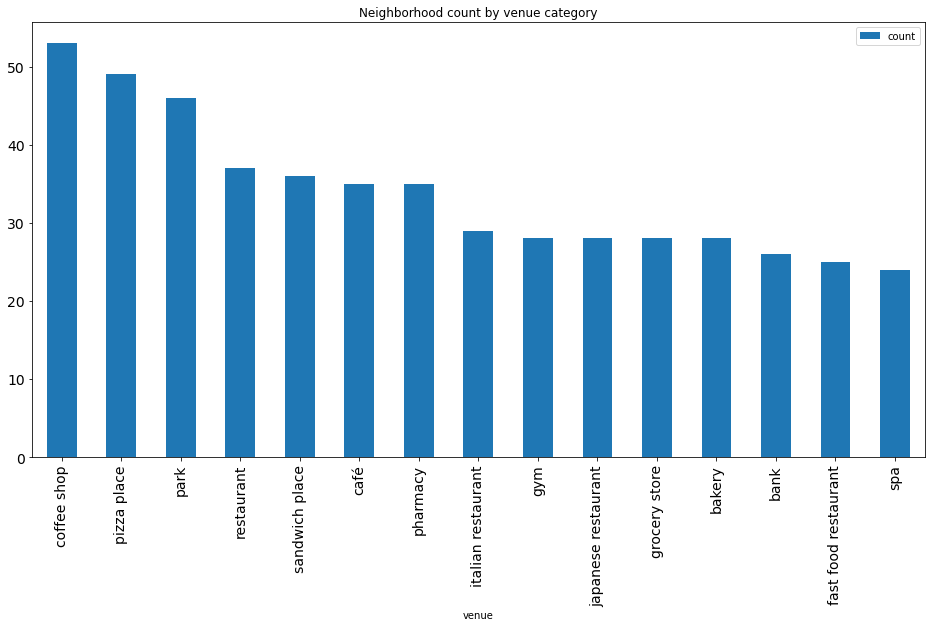

In [87]:
# plot the most frequent categories
categories_plot = category_count_df.head(15)
categories_plot.set_index('venue', inplace = True)

categories_plot.plot(kind = 'bar', title= 'Neighborhood count by venue category', figsize = (16, 8), fontsize = 14)
plt.show()

In [88]:
# let's inspect the most unique categories
category_count_df.tail(15)

,venue,count
172,afghan restaurant,1
108,sake bar,1
81,field,1
255,baby store,1
244,coworking space,1
254,photography studio,1
253,curling ice,1
106,motel,1
83,market,1
29,housing development,1


## Data Preparation

Instead of simple bag of words vector, we will be using tf-idf measure. It stands for term frequency - inverse document frequency and will give us a good measure of number of categories in the neighborhood relative to frequency of the category in the whole town.

In [89]:
# we create a function that calculates the term frequency in the array
def term_frequency(term, termsArray):
    term_count = 0
    for t in termsArray:
        if t == term:
            term_count = term_count + 1
    return term_count

In [90]:
# function that calculates the inverse document frequency, the output is the dictionary with all terms and idf measures
def compute_idfs(df, category_list):
    N = df.shape[0]
    terms_dict = {i: 0 for i in category_list}
    for idx in df.index:
        for term in category_list:
            if term in df.loc[idx]:
                terms_dict[term] = terms_dict[term] + 1
    
    for word, val in terms_dict.items():
        terms_dict[word] = math.log(N/ float(val))
    return terms_dict

In [91]:
idfs = compute_idfs(toronto_categories, all_categories)

In [92]:
# create a function that will convert any query list of categories into the tf-idf vector
def transformer(query, category_list):
    query_vector = []
    for category in category_list:
        tf = term_frequency(category, query)
        if(tf != 0):
            tfidf = tf * idfs[category]
        else:
            tfidf = 0
        query_vector.append(tfidf)
    return query_vector

In [93]:
# use the transformer on every neighborhood in toronto to create dataframe of features
tfidf_data = []
for idx in toronto_categories.index:
    row_tfidf = transformer(toronto_categories.loc[idx], all_categories)
    row = [idx] + row_tfidf
    tfidf_data.append(row)
tfidf_df = pd.DataFrame(data = tfidf_data, columns = ['Postal Code'] + all_categories).set_index('Postal Code')
tfidf_df.head()

,fried chicken joint,gaming cafe,bridal shop,smoke shop,cosmetics shop,theater,diner,furniture / home store,chinese restaurant,business service,...,empanada restaurant,north indian restaurant,carpet store,food court,massage studio,fast food restaurant,wine shop,noodle house,shop & service,shopping mall
Postal Code,,,,,,,,,,,,,,,,,,,,,
M1B,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.406097,0.0,0.0,0.0,0.0
M1C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1E,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1G,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
M1H,1.985915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Modeling

For modeling, we will use a method called latent semantic indexing.

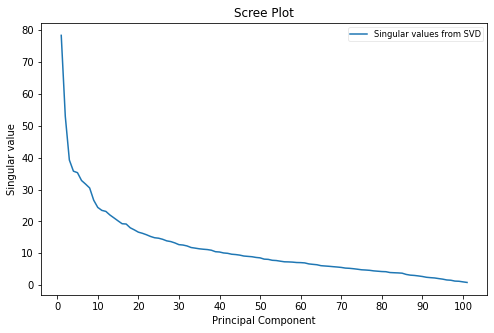

In [94]:
# determine number of components
mod = TruncatedSVD(n_components=101, 
                         algorithm='randomized',
                         n_iter=10, random_state=42)
mod.fit(tfidf_df)

ticks = np.arange(0, 101, step=10)
eigvals = mod.singular_values_
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(101) + 1
plt.plot(sing_vals, eigvals)
plt.xticks(ticks)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular value')

leg = plt.legend(['Singular values from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

In [95]:
# check 20 components based on the scree plot
svd_model20 = TruncatedSVD(n_components=20, 
                         algorithm='randomized',
                         n_iter=10, random_state=42)
category_features20 = svd_model20.fit_transform(tfidf_df)
print(svd_model20.explained_variance_ratio_.sum())

0.7742647133192294


In [112]:
# creating a model with 50 components
svd_model = TruncatedSVD(n_components=50, 
                         algorithm='randomized',
                         n_iter=10, random_state=42)

In [113]:
category_features = svd_model.fit_transform(tfidf_df)
print(svd_model.explained_variance_ratio_)
print(svd_model.explained_variance_ratio_.sum())

[0.16582738 0.11305066 0.06074654 0.05154041 0.05009283 0.04328197
 0.04025214 0.03755105 0.02690089 0.02205982 0.02181379 0.02161902
 0.01956729 0.01792357 0.01639202 0.01490408 0.0148442  0.01289876
 0.01215905 0.01083855 0.01069174 0.01009722 0.00930468 0.00872218
 0.00864268 0.00816779 0.00773366 0.00746862 0.00707297 0.00649294
 0.00639537 0.00610093 0.00556086 0.00542158 0.00525623 0.00508206
 0.00502809 0.00484556 0.00443147 0.00436967 0.00408282 0.0039847
 0.00371962 0.00369261 0.00357207 0.00333411 0.00328855 0.00320705
 0.00303552 0.00296267]
0.9460300525612165


In [114]:
# visualize how the neighborhoods are divided based on our model
tsne = TSNE(n_components = 2, perplexity = 5, init = 'pca', n_iter = 5000, random_state = 12)
coords = tsne.fit_transform(category_features)

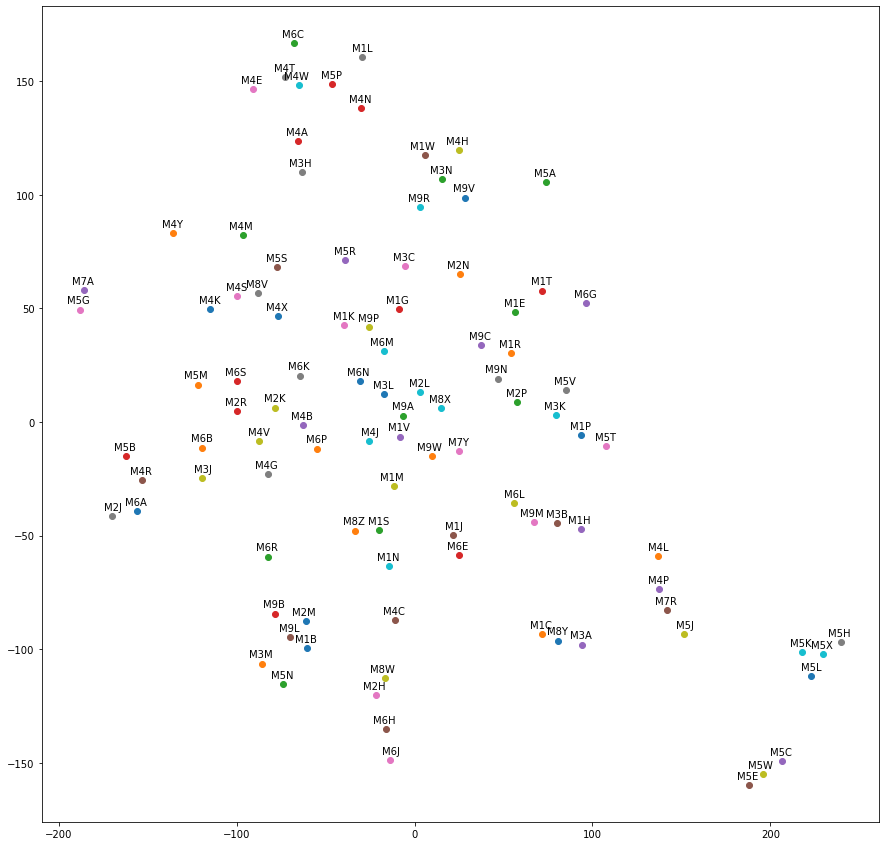

In [115]:
labels = list(tfidf_df.index)

plt.figure(figsize = (15, 15))
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy = (x, y), xytext=(10, 4), textcoords="offset points", ha="right", va="bottom")
    
plt.show()

## Travel Advisor

Recommending a neighborhood based on user's preferences

In [116]:
query1 = ['bakery', 'japanese restaurant', 'park', 'bar']

In [117]:
query_vector1 = transformer(query1, all_categories)
#transpose the vector for correct shape
query_vector_reshaped1 = np.array(query_vector1).reshape(1, -1)

query_svd1 = svd_model.transform(query_vector_reshaped1)
distance_matrix1 = pairwise_distances(query_svd1, category_features, metric='cosine', n_jobs=-1)
# save distances into a dataframe
sorted_df1 = pd.DataFrame({'venues': toronto_categories, 'distance': distance_matrix1[0]}).sort_values(by = 'distance').head()

for idx in sorted_df1.index:
    print(idx, sorted_df1.loc[idx, 'venues'])

M6J ['brewery', 'pizza place', 'asian restaurant', 'bar', 'wine bar', 'korean restaurant', 'ice cream shop', 'greek restaurant', 'beer store', 'new american restaurant', 'cocktail bar', 'cuban restaurant', 'vietnamese restaurant', 'theater', 'art gallery', 'bar', 'yoga studio', 'french restaurant', 'bar', 'japanese restaurant', 'coffee shop', 'record shop', 'bar', 'bakery', 'boutique', 'malay restaurant', 'asian restaurant', 'portuguese restaurant', 'salon / barbershop', 'bagel shop', 'vegetarian / vegan restaurant', 'vietnamese restaurant', "men's store", 'italian restaurant', 'coffee shop', 'bistro', 'mac & cheese joint', 'diner', 'bakery', 'new american restaurant', "men's store", 'coffee shop', 'restaurant', 'café', 'boutique', 'vegetarian / vegan restaurant', 'brazilian restaurant', 'cupcake shop', 'park', 'miscellaneous shop', 'argentinian restaurant', 'restaurant', 'diner', "men's store", 'wine bar', 'coffee shop', 'pub', 'café', 'pizza place', 'gift shop', 'bar', 'music venue',

In [129]:
# check what which neighborhoods will be selected with simple key word search
for idx in toronto_categories.index:
    row = toronto_categories.loc[idx]
    if(query1[0] in row and query1[1] in row and query1[2] in row and query1[3] in row):
        print(idx, query1[0], term_frequency(query1[0], row), 
              query1[1] term_frequency(query1[1], row), 
              query1[2], term_frequency(query1[2], row),
             query1[3], term_frequency(query1[3], row))

M4X bar:  1 park:  3 japanese restaurant:  1 bakery:  3
M5E bar:  1 park:  1 japanese restaurant:  1 bakery:  4
M5J bar:  2 park:  2 japanese restaurant:  1 bakery:  2
M5L bar:  1 park:  1 japanese restaurant:  3 bakery:  1
M5S bar:  2 park:  1 japanese restaurant:  2 bakery:  2
M6J bar:  14 park:  2 japanese restaurant:  1 bakery:  2


In [ ]:
# check how many neighborhoods have bars to get idea of how unique the category is
category_count_df[category_count_df.venue == 'bar']

In [133]:
# inspect the M5X neighborhood which does not have park
row = toronto_categories.loc['M5X']
print(idx, 'bar: ', term_frequency('bar', row), 
      'park: ', term_frequency('park', row), 
      'japanese restaurant: ', term_frequency('japanese restaurant', row),
     'bakery: ', term_frequency('bakery', row))

M9W bar:  2 park:  0 japanese restaurant:  4 bakery:  1


In [134]:
# check occurence of japanese restaurant
category_count_df[category_count_df.venue == 'japanese restaurant']

,venue,count
47,japanese restaurant,28


In [135]:
# check occurence of park
category_count_df[category_count_df.venue == 'park']

,venue,count
235,park,46


Inspect another query

In [176]:
query2 = ['skating rink', 'dog run', 'park']

In [177]:
query_vector2 = transformer(query2, all_categories)
query_vector_reshaped2 = np.array(query_vector2).reshape(1, -1)

query_svd2 = svd_model.transform(query_vector_reshaped2)
distance_matrix2 = pairwise_distances(query_svd2, category_features, metric='cosine', n_jobs=-1)
# save distances into a dataframe
sorted_df2 = pd.DataFrame({'venues': toronto_categories, 'distance': distance_matrix2[0]}).sort_values(by = 'distance').head(10)

for idx in sorted_df2.index:
    print(idx, sorted_df2.loc[idx, 'venues'])

M4C ['skating rink', 'curling ice', 'beer store', 'park', 'intersection', 'construction & landscaping', 'bus stop', 'dance studio', 'skating rink', 'spa', 'athletics & sports', 'video store', 'construction & landscaping', 'atm', 'salon / barbershop', 'pharmacy']
M8W ['pizza place', 'pub', 'gym', 'coffee shop', 'pizza place', 'sandwich place', 'pharmacy', 'dance studio', 'pool', 'skating rink', 'athletics & sports']
M1N ['café', 'general entertainment', 'farm', 'skating rink', 'college stadium']
M1S ['breakfast spot', 'latin american restaurant', 'lounge', 'clothing store', 'hardware store', 'fireworks store', 'skating rink']
M1M ['motel', 'intersection', 'movie theater', 'american restaurant', 'skating rink', 'motel']
M6R ['dog run', 'dessert shop', 'cuban restaurant', 'movie theater', 'eastern european restaurant', 'restaurant', 'italian restaurant', 'coffee shop', 'gift shop', 'gift shop', 'bookstore', 'breakfast spot', 'bar', 'breakfast spot', 'bank', 'light rail station', 'garden',

In [178]:
# check what which neighborhoods will be selected with simple key word search
for idx in toronto_categories.index:
    row = toronto_categories.loc[idx]
    if(query2[0] in row and query2[1] in row):
        print(idx, query2[0], term_frequency(query2[0], row), 
              query2[1], term_frequency(query2[1], row))

In [179]:
category_count_df[category_count_df.venue == 'skating rink']

,venue,count
110,skating rink,6


In [180]:
category_count_df[category_count_df.venue == 'dog run']

,venue,count
74,dog run,5
